In [3]:
import numpy as np
import argparse
from scipy import stats as st
import matplotlib.pyplot as plt

### Let's try a for loop

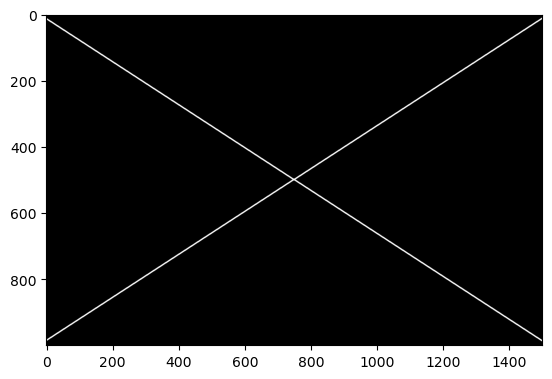

In [4]:
def create_mask(input_array, angle, width): # build mask
    rows, cols = input_array.shape
    center_y, center_x = rows // 2, cols // 2
    theta = np.radians(angle)
    m = np.tan(theta)
    mask = np.zeros((rows, cols), dtype=int)

    # find x coordinates in first quadrant 
    for x in range(center_x, cols):
        y = m * (x - center_x) + center_y
        
        if 0 <= int(y) < rows:
            for w in range(-width // 2, width // 2 + 1):
                if 0 <= int(y) + w < rows:
                    mask[int(y) + w, x] = 1
    
    # reflect mask for other quadrants
    mask = np.maximum(mask, np.flip(mask, axis=0))  # x-axis
    mask = np.maximum(mask, np.flip(mask, axis=1))  # y-axis
    
    return mask

# test it out
input_array = np.zeros((1000, 1500))
angle = 33
width = 4

mask = create_mask(input_array, angle, width)
plt.imshow(mask, cmap='gray')
plt.show()

### Let's try to parallelize the operation and use a multi-angle input array

[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]]


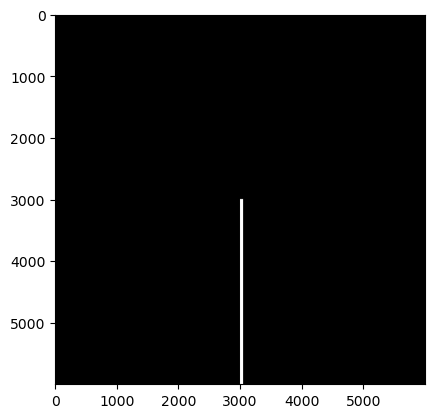

In [ ]:
def star_mask(dct_image, angle, width):
    u_max, v_max = dct_image.shape
    center_u, center_v = u_max // 2, v_max // 2
    mask = np.zeros_like(dct_image, dtype=bool)
    theta = np.radians(angle)
    m = np.tan(theta)
    u_values = np.arange(center_u,u_max).reshape(-1, 1)
    v_values = np.arange(center_v,v_max).reshape(1, -1)

    condition_upper = (v_values >= m * (u_values - center_u) + center_v - width / 2)
    condition_lower = (v_values <= m * (u_values - center_u) + center_v + width / 2)
    print(condition_lower)
    
    mask[center_v:, center_u:] = condition_upper & condition_lower

    return mask

image = np.zeros((6000,6000))
angles = [90]
the_mask = np.zeros_like(image, dtype=bool)
for angle in angles:
    angle_mask = star_mask(image,angle,100)
    the_mask |= angle_mask
plt.imshow(the_mask, cmap='gray')
plt.show()

#### The mask condition causes issues with the lines thickness for angles close to 90, likely bc of the tangent operation that provides an m value that is much higher than the width. we can create a different condition depending on the input angle to avoid this

### Better mask (for all rectangular arrays)

0.83909963117728
0.7002075382097098
0.577350269189626
0.4663076581549986
0.36397023426620245
0.2679491924311227
0.17632698070846506
0.08748866352592397


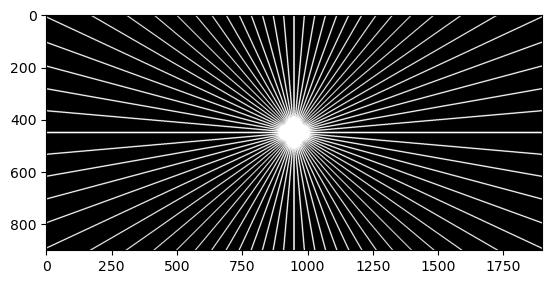

In [ ]:
def star_filter(dct_image, angle, thickness):
    u_max, v_max = dct_image.shape
    center_u, center_v = u_max // 2, v_max // 2
    mask = np.zeros_like(dct_image, dtype=bool)
    theta = np.radians(angle)

    u_values = np.arange(center_u, u_max).reshape(-1, 1) 
    v_values = np.arange(center_v, v_max).reshape(1, -1) 

    if theta == np.pi / 4:
        m = 1
        condition_upper = (v_values >= m * (u_values - center_u) + center_v - thickness / 2)
        condition_lower = (v_values <= m * (u_values - center_u) + center_v + thickness / 2)

    elif 0 < theta < np.pi / 4:
        m = np.tan(theta)
        condition_upper = (v_values >= m * (u_values - center_u) + center_v - thickness / 2)
        condition_lower = (v_values <= m * (u_values - center_u) + center_v + thickness / 2)

    elif np.pi / 2 > theta > np.pi / 4:
        m = 1 / np.tan(theta)
        condition_upper = (u_values >= m * (v_values - center_v) + center_u - thickness / 2)
        condition_lower = (u_values <= m * (v_values - center_v) + center_u + thickness / 2)

    elif theta == 0:
        condition_upper = v_values >= center_v - thickness / 2
        condition_lower = v_values <= center_v + thickness / 2

    elif theta == np.pi / 2:
        condition_upper = u_values >= center_u - thickness / 2
        condition_lower = u_values <= center_u + thickness / 2

    mask[center_u:, center_v:] = condition_upper & condition_lower

    # for non-square arrays
    mask[:center_u, :] = np.flip(mask[center_u + (u_max % 2):, :], axis=0)  # correct the reflection when u_max is odd
    mask[:, :center_v] = np.flip(mask[:, center_v + (v_max % 2):], axis=1)

    return mask

image = np.zeros((900,1900))
angles = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90]
the_mask = np.zeros_like(image, dtype=bool)
for angle in angles:
    angle_mask = star_filter(image,angle,5)
    the_mask |= angle_mask
plt.imshow(the_mask, cmap='gray')
plt.show()